# Exercício 4 - CNN MNIST

---------------------------------------------

### Participants:
 - Francielle Vargas - 9527629
 - Lucas Nunes Sequeira - 9009642
 - Emanuel Huber - 12110113

#### Date: 30/09/2021

---------------------------------------------

#### Descrição e Instrução

Este notebook foi feito para a disciplina SCC5809 - Redes Neurais

No notebook contém

1. A implementação de redes **CNN**
2. Utilização dos modelos no dataset **MNIST**
3. Discussão dos resultados

Para utilizá-lo basta executar todas as células.

_link de acesso ao colab: https://colab.research.google.com/drive/12L4ugC4Z2JEqyZ8ApAMwiJAxSPEoEOkq?usp=sharing_

### Libs

In [ ]:
# Install Libs
!pip install numpy==1.19.5
!pip install tqdm==4.62.0
!pip install plotly==4.4.1
!pip install pandas==1.1.5
!pip install scikit-learn==0.24.2
!pip install tensorflow==2.6.0
!pip install lime==0.2.0.1

In [ ]:
# Math lib
import numpy as np

# Log lib
from tqdm.auto import tqdm

# Visualization Lib
import plotly.express as px
import plotly.graph_objects as go

# Copy for deepcopy
import copy

# Pandas for visualization
import pandas as pd
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Iris data
from sklearn.datasets import load_iris

# Split data
from sklearn.model_selection import train_test_split

# Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import accuracy_score

# Feature selection
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel

# TensorFlow e tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model

# Explainable AI
import lime
from lime import lime_image

# Model customization for Lime
from functools import partial

# Seed
SEED = 42

# Set random seed
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Load Data

In [ ]:
# Get MNIST data
mnist = keras.datasets.mnist

# Load datasets (train/test)
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Set class names
CLASS_NAMES = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Shape of train/test
train_images.shape, test_images.shape

((60000, 28, 28), (10000, 28, 28))

#### Visualize data

In [ ]:
def show_image(image, label):
  '''
  Plot image with matplotlib
  '''

  # Initialize figure
  plt.figure()

  # Plot image
  plt.imshow(train_images[0])

  # Plot configuration / display
  plt.xticks([])
  plt.yticks([])
  plt.colorbar()
  plt.grid(False)
  plt.xlabel('label: ' + str(CLASS_NAMES[label]))
  plt.show()

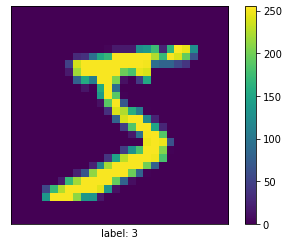

In [ ]:
index = 10

show_image(train_images[index], train_labels[index])

### Preprocess Data

In [ ]:
# Normalize data with max pixel value (255)

train_images_normalized = train_images / 255.0
test_images_normalized = test_images / 255.0

#### Visualize Data

In [ ]:
def show_images(images, labels):
  '''
  Plot images with matplotlib
  '''

  # Initialize figure
  plt.figure(figsize=(10,10))

  # Num of images
  num_images = len(images)
  sqrt_num_images = np.ceil(np.sqrt(num_images))

  # Iterate over images
  for i in range(num_images):
    # Add subplot
    plt.subplot(sqrt_num_images,sqrt_num_images,i+1)

    # Image configuration
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
    plt.xlabel('label: ' + str(CLASS_NAMES[labels[i]]))

  # Show image
  plt.show()

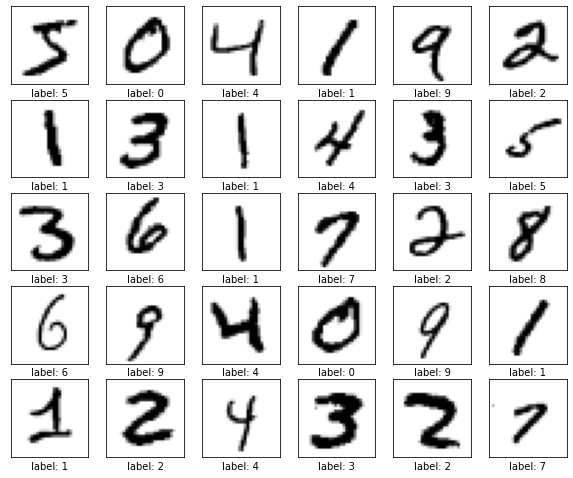

In [ ]:
show_images(train_images_normalized[0:30], train_labels[0:30])

### Build Models

- Modelagem de quatro modelos distintos
  - Baseline (simples ANN)
  - CNN-1-A (CNN com uma camada de convolução e 32 filtros)
  - CNN-1-B (CNN com uma camada de convolução e 48 filtros)
  - CNN-2 (CNN com duas camadas de convolução, 32 filtros na primeira e 16 filtros na segunda)

In [ ]:
def build_model(layers, name = None):
  '''
  Build untrained keras model given list of sequential Layers
  '''

  # Build model
  model = keras.Sequential(layers=layers, name=name)

  # Compile model
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  
  return model

#### Baseline Model

Model: "Baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


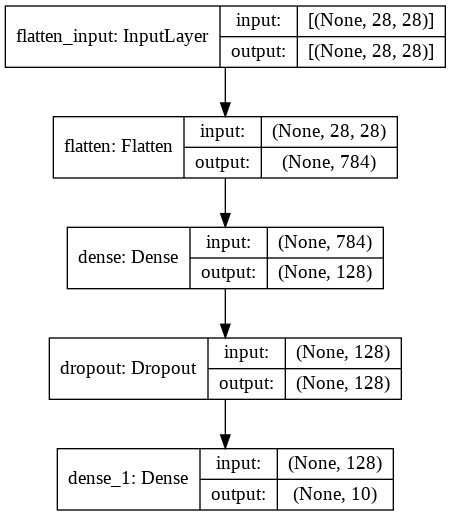

In [ ]:
# Layers
layers = [
          keras.layers.Flatten(input_shape=(28, 28)),
          keras.layers.Dense(128, activation='relu'),
          keras.layers.Dropout(0.05),
          keras.layers.Dense(10, activation='softmax')
]

# Get model
baseline_model = build_model(layers = layers, name = 'Baseline')

# Health Check
output = baseline_model(train_images_normalized[:1])
assert output.shape == [1, 10]

# Visualize model
baseline_model.summary()
plot_model(baseline_model, show_shapes=True, show_layer_names=True)

#### CNN-1-A Model

Model: "CNN-1-A"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 26, 32)            2720      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 13, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 416)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               53376     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290

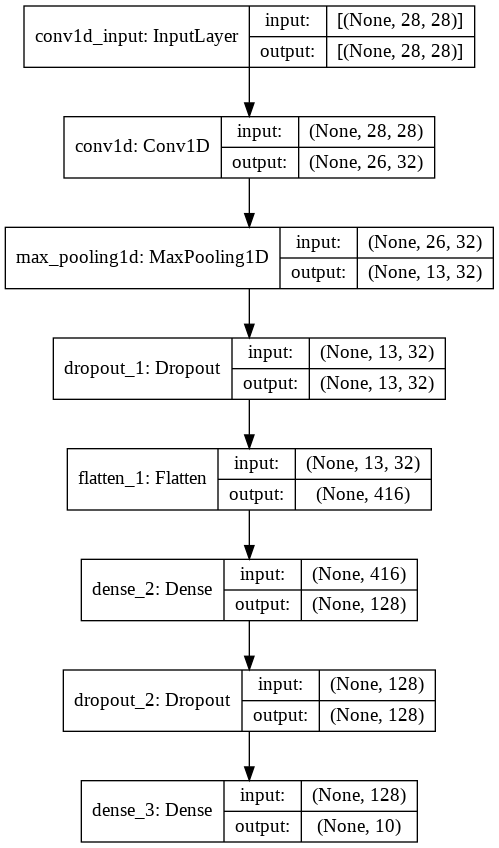

In [ ]:
# hparams
# first convolution
cnn1_a_filters = 32
cnn1_a_kernel_size = 3
pool1_size = 2

# Layers
layers = [
          keras.layers.Conv1D(cnn1_a_filters, cnn1_a_kernel_size, activation='relu', input_shape=(28, 28)),
          keras.layers.MaxPooling1D(pool1_size),
          keras.layers.Dropout(0.05),
          keras.layers.Flatten(),
          keras.layers.Dense(128, activation='relu'),
          keras.layers.Dropout(0.05),
          keras.layers.Dense(10, activation='softmax')
]

# Get model
cnn1_a_model = build_model(layers = layers, name = 'CNN-1-A')

# Health Check
output = cnn1_a_model(train_images_normalized[:1])
assert output.shape == [1, 10]

# Visualize model
cnn1_a_model.summary()
plot_model(cnn1_a_model, show_shapes=True, show_layer_names=True)

#### CNN-1-B Model

Model: "CNN-1-B"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 26, 48)            4080      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 48)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 13, 48)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 624)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               80000     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290

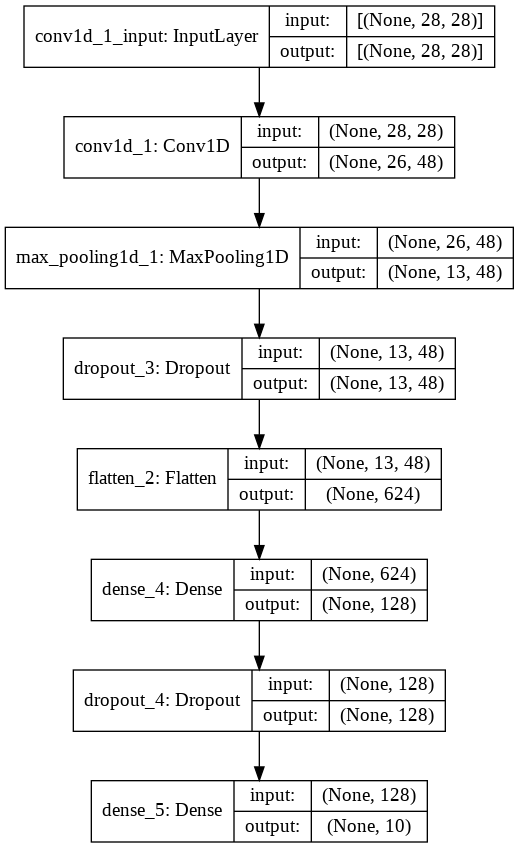

In [ ]:
# hparams
# first convolution
cnn1_b_filters = 48
cnn1_b_kernel_size = 3
pool1_size = 2

# Layers
layers = [
          keras.layers.Conv1D(cnn1_b_filters, cnn1_b_kernel_size, activation='relu', input_shape=(28, 28)),
          keras.layers.MaxPooling1D(pool1_size),
          keras.layers.Dropout(0.05),
          keras.layers.Flatten(),
          keras.layers.Dense(128, activation='relu'),
          keras.layers.Dropout(0.05),
          keras.layers.Dense(10, activation='softmax')
]

# Get model
cnn1_b_model = build_model(layers = layers, name = 'CNN-1-B')

# Health Check
output = cnn1_b_model(train_images_normalized[:1])
assert output.shape == [1, 10]

# Visualize model
cnn1_b_model.summary()
plot_model(cnn1_b_model, show_shapes=True, show_layer_names=True)

#### CNN-2 Model

Model: "CNN-2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 26, 32)            2720      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 13, 32)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 13, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11, 16)            1552      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5, 16)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 16)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 80)                0     

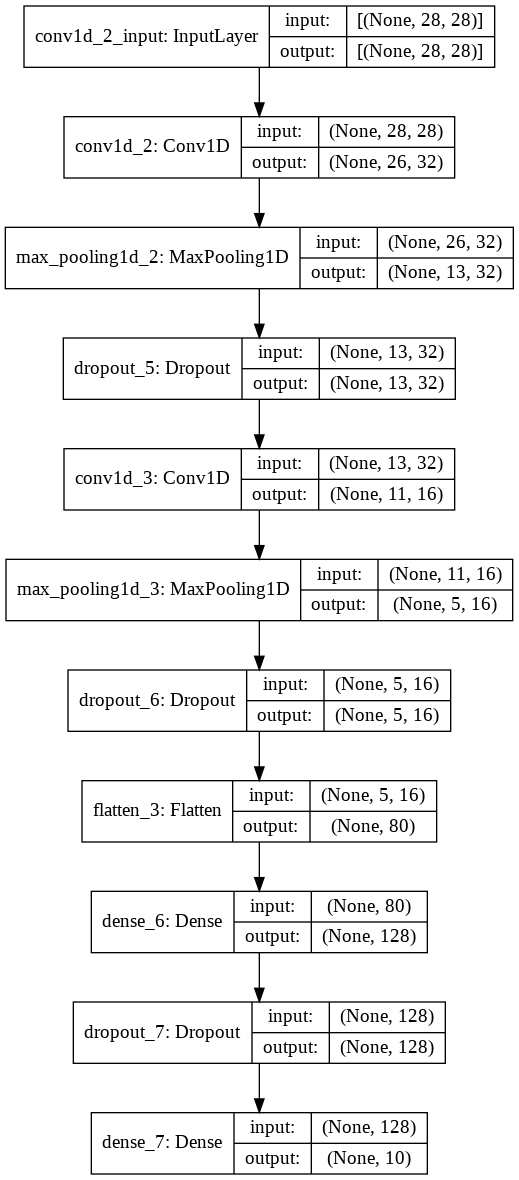

In [ ]:
# hparams
# first convolution
cnn1_filters = 32
cnn1_kernel_size = 3
pool1_size = 2
# second convolution
cnn2_filters = 16
cnn2_kernel_size = 3
pool2_size = 2

# Layers
layers = [
          keras.layers.Conv1D(cnn1_filters, cnn1_kernel_size, activation='relu', input_shape=(28, 28)),
          keras.layers.MaxPooling1D(pool1_size),
          keras.layers.Dropout(0.05),
          keras.layers.Conv1D(cnn2_filters, cnn2_kernel_size, activation='relu'),
          keras.layers.MaxPooling1D(pool2_size),
          keras.layers.Dropout(0.05),
          keras.layers.Flatten(),
          keras.layers.Dense(128, activation='relu'),
          keras.layers.Dropout(0.05),
          keras.layers.Dense(10, activation='softmax')
]

# Get model
cnn2_model = build_model(layers = layers, name = 'CNN-2')

# Health Check
output = cnn2_model(train_images_normalized[:1])
assert output.shape == [1, 10]

# Visualize model
cnn2_model.summary()
plot_model(cnn2_model, show_shapes=True, show_layer_names=True)

### Train Models

- Treinamento dos modelos considerando:
  - 10 épocas
  - Adam optimizer
  - loss: sparse_categorical_crossentropy
  - métrica: accuracy

#### Baseline

In [ ]:
# num epochs
epochs = 10

# train
baseline_history = baseline_model.fit(train_images_normalized, train_labels, epochs=epochs)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2702 - accuracy: 0.9215
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1208 - accuracy: 0.9647
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0842 - accuracy: 0.9740
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0640 - accuracy: 0.9800
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0510 - accuracy: 0.9843
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0435 - accuracy: 0.9856
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0348 - accuracy: 0.9886
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0310 - accuracy: 0.9897
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0247 - accuracy: 0.9920
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.023

#### CNN-1-A

In [ ]:
# num epochs
epochs = 10

# train
cnn1_a_history = cnn1_a_model.fit(train_images_normalized, train_labels, epochs=epochs)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2520 - accuracy: 0.9249
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1014 - accuracy: 0.9690
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0714 - accuracy: 0.9783
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0561 - accuracy: 0.9826
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0452 - accuracy: 0.9857
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0355 - accuracy: 0.9883
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0323 - accuracy: 0.9897
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0271 - accuracy: 0.9911
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0240 - accuracy: 0.9919
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.020

#### CNN-1-B

In [ ]:
# num epochs
epochs = 10

# train
cnn1_b_history = cnn1_b_model.fit(train_images_normalized, train_labels, epochs=epochs)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2270 - accuracy: 0.9318
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0845 - accuracy: 0.9735
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0586 - accuracy: 0.9822
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0452 - accuracy: 0.9855
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0367 - accuracy: 0.9880
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0292 - accuracy: 0.9903
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0266 - accuracy: 0.9913
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0209 - accuracy: 0.9930
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0185 - accuracy: 0.9935
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.017

#### CNN-2

In [ ]:
# num epochs
epochs = 10

# train
cnn2_history = cnn2_model.fit(train_images_normalized, train_labels, epochs=epochs)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3211 - accuracy: 0.9014
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1248 - accuracy: 0.9610
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0932 - accuracy: 0.9707
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0764 - accuracy: 0.9756
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0698 - accuracy: 0.9779
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0619 - accuracy: 0.9798
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0569 - accuracy: 0.9821
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0515 - accuracy: 0.9831
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0492 - accuracy: 0.9846
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.045

### Visualize Train

**Resultados (treino):**

| Modelo   | Loss  | Acurácia |
|----------|-------|----------|
| Baseline | 0.023 | 0.992    |
| CNN-1-A  | 0.020 | 0.993    |
| CNN-1-B  | 0.017 | 0.994    |
| CNN-2    | 0.046 | 0.985    |

In [ ]:
# X values (epochs)
x = np.arange(1, epochs+1)

# Y values (accuracy)
baseline_accuracy = baseline_history.history['accuracy']
cnn1_a_accuracy = cnn1_a_history.history['accuracy']
cnn1_b_accuracy = cnn1_b_history.history['accuracy']
cnn2_accuracy = cnn2_history.history['accuracy']

# Create figure / add traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=baseline_accuracy,
                    mode='lines',
                    name='Baseline Model'))

fig.add_trace(go.Scatter(x=x, y=cnn1_a_accuracy,
                    mode='lines',
                    name='CNN-1-A Model'))

fig.add_trace(go.Scatter(x=x, y=cnn1_b_accuracy,
                    mode='lines',
                    name='CNN-1-B Model'))

fig.add_trace(go.Scatter(x=x, y=cnn2_accuracy,
                    mode='lines',
                    name='CNN-2 Model'))

fig.update_layout(title="Train Accuracy", xaxis_title="Epoch", yaxis_title="Accuracy")
fig.show()

In [ ]:
# X values (epochs)
x = np.arange(1, epochs+1)

# Y values (loss)
baseline_loss = baseline_history.history['loss']
cnn1_a_loss = cnn1_a_history.history['loss']
cnn1_b_loss = cnn1_b_history.history['loss']
cnn2_loss = cnn2_history.history['loss']

# Create figure / add traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=baseline_loss,
                    mode='lines',
                    name='Baseline Model'))

fig.add_trace(go.Scatter(x=x, y=cnn1_a_loss,
                    mode='lines',
                    name='CNN-1-A Model'))

fig.add_trace(go.Scatter(x=x, y=cnn1_b_loss,
                    mode='lines',
                    name='CNN-1-B Model'))

fig.add_trace(go.Scatter(x=x, y=cnn2_loss,
                    mode='lines',
                    name='CNN-2 Model'))

fig.update_layout(title="Train Loss", xaxis_title="Epoch", yaxis_title="Loss")
fig.show()

### Evaluate Models

**Resultados (teste):**

| Modelo   | Loss  | Acurácia |
|----------|-------|----------|
| Baseline | 0.074 | 0.980    |
| CNN-1-A  | 0.043 | 0.987    |
| CNN-1-B  | 0.034 | 0.987    |
| CNN-2    | 0.039 | 0.987    |

#### Baseline

In [ ]:
test_loss, test_acc = baseline_model.evaluate(test_images_normalized, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.0737 - accuracy: 0.9799

Test accuracy: 0.9799000024795532


#### CNN-1-A

In [ ]:
test_loss, test_acc = cnn1_a_model.evaluate(test_images_normalized, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.0439 - accuracy: 0.9869

Test accuracy: 0.9868999719619751


#### CNN-1-B

In [ ]:
test_loss, test_acc = cnn1_b_model.evaluate(test_images_normalized, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.0394 - accuracy: 0.9869

Test accuracy: 0.9868999719619751


#### CNN-2

In [ ]:
test_loss, test_acc = cnn2_model.evaluate(test_images_normalized, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.0391 - accuracy: 0.9871

Test accuracy: 0.9871000051498413


### Make Predictions

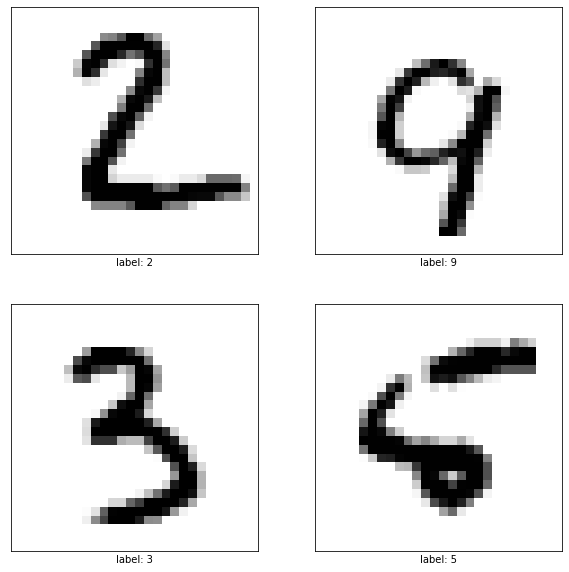

In [ ]:
# Select 4 sample images
test_indexes = [1, 16, 32, 8]
test_images_selected = test_images_normalized[test_indexes]
test_labels_selected = test_labels[test_indexes]

# Visualize samples
show_images(test_images_selected, test_labels_selected)

In [ ]:
def predict(images, model):
  '''
  Make prediction and return most probable classes
  '''

  # Predictions
  logits = model.predict(images)

  # Apply argmax
  predictions = np.argmax(logits, axis=1)

  return predictions

#### Baseline

In [ ]:
test_labels_predicted = predict(test_images_selected, baseline_model)

print("Baseline Model predictions:", test_labels_predicted)
print("Baseline Model accuracy:", baseline_model.evaluate(test_images_selected, test_labels_selected, verbose=0)[1])

Baseline Model predictions: [2 9 3 5]
Baseline Model accuracy: 1.0


#### CNN-1-A

In [ ]:
test_labels_predicted = predict(test_images_selected, cnn1_a_model)

print("CNN-1 Model predictions:", test_labels_predicted)
print("CNN-1 Model accuracy:", cnn1_a_model.evaluate(test_images_selected, test_labels_selected, verbose=0)[1])

CNN-1 Model predictions: [2 9 3 5]
CNN-1 Model accuracy: 1.0


#### CNN-1-B

In [ ]:
test_labels_predicted = predict(test_images_selected, cnn1_b_model)

print("CNN-1 Model predictions:", test_labels_predicted)
print("CNN-1 Model accuracy:", cnn1_b_model.evaluate(test_images_selected, test_labels_selected, verbose=0)[1])

CNN-1 Model predictions: [2 9 3 5]
CNN-1 Model accuracy: 1.0


#### CNN-2

In [ ]:
test_labels_predicted = predict(test_images_selected, cnn2_model)

print("CNN-2 Model predictions:", test_labels_predicted)
print("CNN-2 Model accuracy:", cnn2_model.evaluate(test_images_selected, test_labels_selected, verbose=0)[1])

CNN-2 Model predictions: [2 9 3 5]
CNN-2 Model accuracy: 1.0


### Model explainability

#### Preparing model and data



In [ ]:
def lime_predict(self, image):
  return self.predict(image[...,0])

cnn2_model.lime_predict = partial(lime_predict, cnn2_model)

In [ ]:
def to_rgb(x):
    x_rgb = np.zeros((x.shape[0], 28, 28, 3))
    for i in range(3):
        x_rgb[..., i] = x
    return x_rgb

test_images_selected_3d = to_rgb(test_images_selected)

#### Running LIME

In [ ]:
test_images_explained = []
for image in test_images_selected_3d:
  explainer = lime_image.LimeImageExplainer(random_state=SEED)
  explanation = explainer.explain_instance(
          image, 
          cnn2_model.lime_predict
  )
  image_out, mask = explanation.get_image_and_mask(
          cnn2_model.lime_predict(
                np.expand_dims(image, 0)
          ).argmax(axis=1)[0],
          positive_only=True, 
          hide_rest=False)
  test_images_explained.append( mark_boundaries(image_out, mask) )

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

#### Visualizing explanations

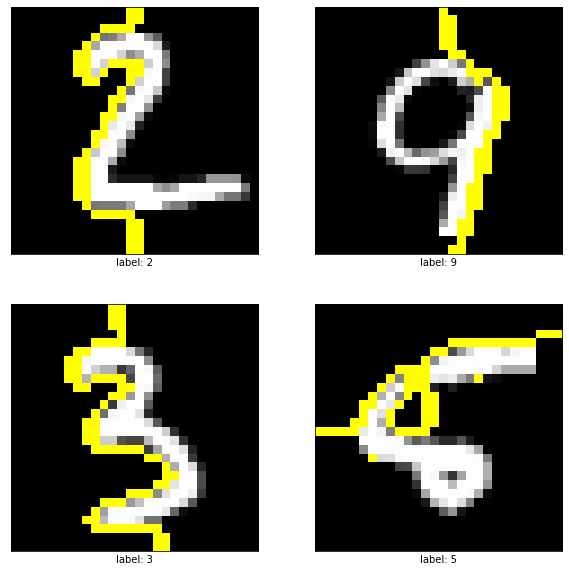

In [ ]:
show_images(test_images_explained, test_labels_selected)

### Observações Finais

- Notamos que para o caso do reconhecimento de dígito, todas as redes CNN performaram melhor no conjunto de testes do que uma simples ANN. Também foi observado de que todos os modelos baseados na CNN possuem menor número de parâmetros treináveis, ou seja, menor custo computacional para treinamento e inferência em comparação a ANN.

- Observamos também que, apesar das redes CNN-1-A e CNN-1-B (redes com apenas uma camada de convolução, mas quantidade de filtros distintos) terem performado melhor do que a CNN-2 (rede com 2 camadas de convolução) no conjunto de treino; a CNN-2 teve um desempenho tão bom quanto no conjunto de teste; mostrando portanto sua maior capacidade de generalização.